In [1]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # 디바이스 설정
print("now device >> ", DEVICE)

now device >>  cpu


### Parameters

In [3]:

RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10 # MNIST 데이터셋은 10개의 클래스를 가지고 있다

### Transforms 정의
숫자 이미지에 회전, 반전 등 어그먼테이션 넣으면 6 -> 9가 되는 등 문제가 있을 수도 있으니 넣지 않는다

In [4]:
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.ToTensor()])  

### Data set 다운받고 생성

In [5]:
train_dataset = datasets.MNIST(root='mnist_data',
                          train = True,
                          transform=transform,
                          download=True)
valid_dataset = datasets.MNIST(root='mnist_data',
                          train = False,
                          transform=transform)

### Data loader 정의

In [6]:
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                         shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset,
                          batch_size = BATCH_SIZE,
                         shuffle = False)

### 불러온 MNIST 데이터 확인하기

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3664\2761840132.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


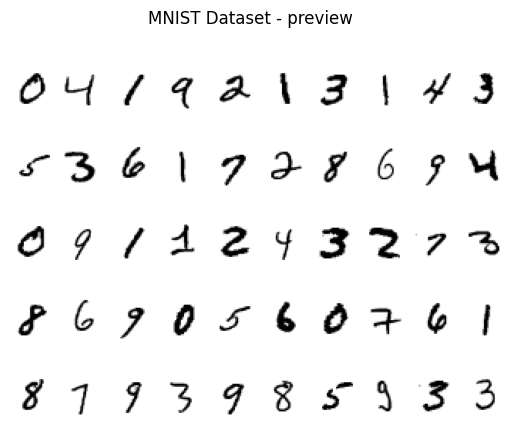

In [7]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
    
fig.suptitle('MNIST Dataset - preview')
fig.show()

### 모델 클래스 정의

In [8]:
class LeNet5(nn.Module):
    
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        '''
        LeNet5 네트워크의 피처 추출 부분
        '''
        
        # Feature extractor (특징 추출기) 구성
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # 흑백이니 인풋 채널 1
            ### 텐서로 바꾸었을 때 (32, 6, 높이, 너비) = (이미지 사이즈, 채널 수, 높이, 너비)
            nn.Tanh(),  
            nn.AvgPool2d(kernel_size=2), ## (32, 6, 높이/2, 너비/2) ->>> feature map 크기가 절반이 됩니다
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            ## (32, 6, 높이/2, 너비/2) =>>> (32, 16, 높이/2, 너비/2) =>>>)
            nn.Tanh(), 
            nn.AvgPool2d(kernel_size=2),
            ## (32, 16, 높이/2, 너비/2) -> (32, 16, 높이/4, 너비/4) =>>> Feature map 크기가 절반이 됩니다
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            ## (32, 120, 높이/4, 너비/4) -> 최종 피처맵 크기
            nn.Tanh()   
        )
        '''
        LeNet5 모델의 분류기 부분
        LeNet5 네트워크의 피처 추출 부분 -> out_channels=120 -> in_features -> 84 (특성 차원 축소) -> 클래스 개수에 대한
        로짓을 출력합니다 -> 소프트맥스 함수 -> 클래스별 확률로 변환
        '''
        
        # Classifier (분류기) 구성
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),  
            nn.Linear(in_features=84, out_features=n_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)  # 특징 추출기로 이미지의 특징을 추출
        x = torch.flatten(x, 1)        # 1차원 벡터로 변환하여 FC(Fully-Connected) 계층에 입력
        logits = self.classifier(x)    # 분류기를 통해 클래스별 점수 (logits)를 얻기
        probs = F.softmax(logits, dim=1)  # logit을 확률값으로 변환하여 예측 확률값을 얻기
        return logits, probs


### 전체 data_loader에 대한 예측의 정확도를 계산하는 함수

In [9]:
def get_accuracy(model, data_loader, device):
    
    correct_pred = 0
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
            
    return correct_pred.float() / n

### training과 validation_loss를 시각화하는 함수

In [10]:
def plot_losses(train_losses, valid_losses):  # Corrected the argument name here
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')
    
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title='Loss over epochs',
          xlabel='Epoch',
          ylabel='Loss')
    ax.legend()
    plt.show()  # Changed fig.show() to plt.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')


### training loop의 training 단계에 대한 함수

In [11]:
def train(train_loader, model, criterion, optimizer, device):
    
    model.train() ## 모델을 학습모드로 설정
    running_loss = 0 ## running_loss 0으로 초기화
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)  ## cuda / cpu
        y_true = y_true.to(device)
        
        # 순전파
        y_hat, _ = model(X)         #########  y_hat, _ -----> 예측, 확률값(probs)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)     ### 배치사이즈 만큼 처리를 위한 임시 변수
        
        # 역전파
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)   # 평균 손실계산
    return model, optimizer, epoch_loss

### training loop의 validation 단계에 대한 함수

In [12]:
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0  ### 0으로 초기화
    
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        # 순전파와 손실 기록하기
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)
        
    epoch_loss = running_loss / len(valid_loader.dataset)
    
    return model, epoch_loss

### 전체 training loop를 정의하는 함수

In [13]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # metrics를 저장하기 위한 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    
    # model 학습하기
    for epoch in range(0, epochs):
        
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            
        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch + 1}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
                
    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)



16:24:34 --- Epoch: 1	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
16:25:04 --- Epoch: 2	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
16:25:33 --- Epoch: 3	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
16:26:05 --- Epoch: 4	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
16:26:50 --- Epoch: 5	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.24	Valid accuracy: 98.73
16:27:23 --- Epoch: 6	Train loss: 0.0297	Valid loss: 0.0444	Train accuracy: 99.35	Valid accuracy: 98.61
16:28:11 --- Epoch: 7	Train loss: 0.0244	Valid loss: 0.0408	Train accuracy: 99.54	Valid accuracy: 98.84
16:28:50 --- Epoch: 8	Train loss: 0.0215	Valid loss: 0.0451	Train accuracy: 99.49	Valid accuracy: 98.74
16:29:34 --- Epoch: 9	Train loss: 0.0192	Valid loss: 0.0466	Train accuracy: 99.50	Valid accuracy: 98.57
16:30:05 --- Epoch: 10	Train loss: 0.0175	Valid loss: 0.0447	Tra

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3664\4228274355.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


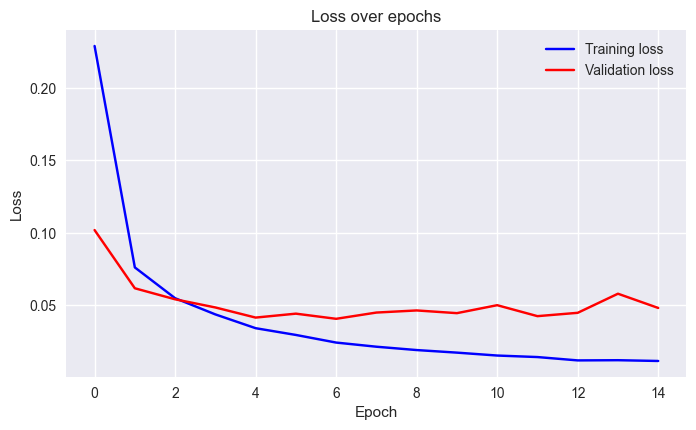

In [14]:
if __name__ == "__main__":
    torch.manual_seed(RANDOM_SEED)
    
    model = LeNet5(N_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader,
                                       valid_loader, N_EPOCHS, DEVICE)